![example](images/director_shot.jpeg)

# PROJECT TITLE: MICROSOFT MOVIE PROJECT 
## Author: Nelson Kibet kemboi 

### OVERVIEW 
In the recent past, there has been increased production of movies in America which has drawn attention to Microsot company. Hence the company has decided to produce thier own movies. Since microsoft company has no idea about movie recording and production, this report will seek to analyse data sets pertaining to movie studio creation and give insights as to why the company should utilize this available venture. In this case we will use exploratory data analysis to pitch recommendations to their stakeholders. 

## Business Problem

In order to invest in this new venture there are factors to be considered. This is important since microsft should not invest in an unworthy project vis a vis their main mandate. This project will find the followig issues hence helping Microsoft map their investment proposal: 
    
***
Questions to consider:
* Finding the best perfoming movies studios. 
* Comparing the cost of production in relation to the revenue earned.
* comparison between various based on ratings and people preference. 
* The microsoft competitors so as to see what best their do
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

## DATA CLEANING PROCESS

In [208]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
%matplotlib inline

In [209]:
# Here we run the code to unzip and explore the data
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip, path='ZippedData')
    
# Created a new file called im.db
# Added the file to .gitignore because it's too big to upload to GitHub

### Loading bom.movie_gross.csv

In [210]:
# Creating a connection to the Database
conn = sqlite3.connect('zippedData/im.db')

In [211]:
#connecting to the SQL tables 
pd.read_sql("""
SELECT *
FROM sqlite_schema
WHERE type='table'
""", conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [212]:
# reading first databe 
df1= pd.read_sql("""
SELECT *
FROM movie_ratings;
""", conn)
df1.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [213]:
# readingsecond databe
df2= pd.read_sql("""
SELECT *
FROM movie_basics;
""", conn)
df2.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### joining the two tables (movie_basics and movie_ratings)

In [214]:
#writing the code to join the two tables 
df3 = pd.read_sql("""
SELECT primary_title, start_year, genres, averagerating, numvotes
FROM movie_basics AS MB
JOIN movie_ratings AS MR
    ON MB.movie_id = mr.movie_id 
    WHERE numvotes> 500000 AND averagerating BETWEEN 6.0 AND 9.5
    ORDER BY averagerating DESC
    LIMIT 50;
""", conn)
df3.head()

,primary_title,start_year,genres,averagerating,numvotes
0,Inception,2010,"Action,Adventure,Sci-Fi",8.8,1841066
1,Interstellar,2014,"Adventure,Drama,Sci-Fi",8.6,1299334
2,The Intouchables,2011,"Biography,Comedy,Drama",8.5,677343
3,Whiplash,2014,"Drama,Music",8.5,616916
4,Avengers: Infinity War,2018,"Action,Adventure,Sci-Fi",8.5,670926


In [215]:
# groupig the data by genre to identify the their frequency based on the views
genres_grouped = df3['genres'].value_counts().head()
genres_grouped

Action,Adventure,Sci-Fi       10
Action,Adventure,Comedy        3
Adventure,Animation,Comedy     3
Adventure,Drama,Fantasy        2
Adventure,Drama,Sci-Fi         2
Name: genres, dtype: int64

In [216]:
#checking for missing values in the limited joined tables 
df3.isna().sum()

primary_title    0
start_year       0
genres           0
averagerating    0
numvotes         0
dtype: int64

It can be seen that the above joined tables have no missing values when the rows are limited by 50

In [217]:
#Identifying the mean of the sorted tables and remove the outlier that is too much spread outside data range 
genres_sorted_mean = pd.DataFrame(df3.groupby("genres")["numvotes"].mean()).sort_values(by="numvotes", ascending= False).iloc[:10]
genres_sorted_mean

,numvotes
genres,
"Action,Thriller",1.387769e+06
"Drama,Western",1.211405e+06
"Biography,Crime,Drama",1.035358e+06
"Mystery,Thriller",1.005960e+06
"Adventure,Drama,Sci-Fi",9.897250e+05
"Action,Adventure,Sci-Fi",8.046928e+05
"Action,Adventure,Comedy",7.712503e+05
"Drama,Mystery,Thriller",7.615920e+05
"Adventure,Family,Fantasy",7.196290e+05


In [253]:
#iterating over the movie_basics table and joining with directors and movie_ratings tables
directors_rating = pd.read_sql("""
      SELECT movie_basics.primary_title, averagerating, primary_name
      FROM directors
      JOIN persons ON directors.person_id = persons.person_id
      JOIN movie_basics ON movie_basics.movie_id = directors.movie_id
      JOIN movie_ratings ON movie_ratings.movie_id = movie_basics.movie_id;     
              """, conn)
directors_rating

,primary_title,averagerating,primary_name
0,Life's a Beach,3.9,Tony Vitale
1,Steve Phoenix: The Untold Story,5.5,Bill Haley
2,The Babymakers,5.0,Jay Chandrasekhar
3,The Babymakers,5.0,Jay Chandrasekhar
4,Bulletface,5.8,Albert Pyun
...,...,...,...
181382,Reversing Roe,7.4,Anne Sundberg
181383,The Princess Switch,6.0,Mike Rohl
181384,The Princess Switch,6.0,Mike Rohl
181385,Doozy,6.7,Richard Squires


In [259]:

directors_info =pd.read_sql(
    """SELECT DISTINCT primary_name, original_title, averagerating
	FROM persons pr
	JOIN directors dr 
		ON pr.person_id = dr.person_id
	JOIN movie_basics mb 
		ON dr.movie_id = mb.movie_id 
	JOIN movie_ratings mr 
		ON mb.movie_id = mr.movie_id""", conn)
directors_info

,primary_name,original_title,averagerating
0,Ruel S. Bayani,Paano na kaya,6.4
1,Ruel S. Bayani,No Other Woman,6.4
2,Ruel S. Bayani,One More Try,5.8
3,Ruel S. Bayani,Kasal,7.9
4,Bryan Beasley,Not Such a Bad Guy: Conversations with Dabney ...,8.9
...,...,...,...
85943,Benjamin Ovesen,Gina,7.4
85944,Frank W Chen,Late Life: The Chien-Ming Wang Story,5.8
85945,Prasobh Vijayan,Lilli,5.7
85946,Grzegorz Jankowski,Polskie gówno,5.2


In [263]:
#grouping the directors name and rating and sorting them in descending order 
#Converting to dataframe for easier visualization 
populaton_of_dir = pd.DataFrame(directors_rating.groupby('primary_name')['averagerating'].mean()).sort_values(by = 'averagerating', ascending= False).head(20)
populaton_of_dir

,averagerating
primary_name,
Chad Carpenter,10.0
Loreto Di Cesare,10.0
Tristan David Luciotti,10.0
Michiel Brongers,10.0
Lindsay Thompson,10.0
Ivana Diniz,10.0
Emre Oran,10.0
Masahiro Hayakawa,10.0
Stephen Peek,10.0


In [258]:
joining_tables = pd.read_sql('''SELECT primary_name, COUNT(primary_name), averagerating
FROM persons AS p
JOIN directors AS d ON p.person_id = d.person_id
JOIN movie_basics AS mb ON mb.movie_id = d.movie_id
JOIN movie_ratings AS mr ON mr.movie_id = mb.movie_id
GROUP BY primary_name, averagerating
HAVING AVG(averagerating) > 9 AND COUNT(primary_name) > 5
ORDER BY averagerating DESC;
''', conn)
director_rated

,primary_name,COUNT(primary_name),averagerating
0,Damir Radic,7,9.2
1,Fan Li,6,9.2
2,Georges Chamchoum,6,9.2
3,Nuo Wang,6,9.2
4,Yihui Ye,6,9.2
5,Chi-jan Hou,6,9.1
6,Chun-Yi Hsieh,6,9.1
7,Corey Lubowich,12,9.1
8,Li Cho,6,9.1


From data combined from two tables i was able to find the most top genres 
when combining the two data sets into one data frame, i filtered the highest rated and most voted movies to come up with a combined data frame (df3).
From this data frame there are no duplicates or null values.
From (df3) dataset I was able to find the top 10 most popular genres with Action,Adventure,Sci-Fi being the leading

### Loading bom.movie_gross.csv

In [222]:
#loading the movie_gross dataset and checking the data overview 
gross_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [223]:
#identifying missing values on the dataset and converting them to percentages based on null values
gross_df.isna().sum()/len(gross_df)*100

title              0.000000
studio             0.147623
domestic_gross     0.826690
foreign_gross     39.858282
year               0.000000
dtype: float64

It can be seen that movie_gross dataset has some missing values the highest being foreign_gross column with 39% of missing values. The other two are domestic_gross and studio which have lesser missing values. It is recommendable to drop all of foreign_gross column and fill the other null values or drop only rows with null values

In [224]:
#checking for duplicates in the data
gross_df.duplicated().sum()

0

From the results above there are no duplicated values in the dataset

In [225]:
#The code below is used to check for null values in the dataset and converting it to dataframe to check in tabular form 
gross_df[gross_df.isna()]

,title,studio,domestic_gross,foreign_gross,year
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
3382,NaN,NaN,NaN,NaN,NaN
3383,NaN,NaN,NaN,NaN,NaN
3384,NaN,NaN,NaN,NaN,NaN
3385,NaN,NaN,NaN,NaN,NaN


In [226]:
#Writing a function that drops the null values in studio rows and leaving other columns with values
gross_df = gross_df[gross_df['studio'].notna()]
gross_df.isna().sum()

title                0
studio               0
domestic_gross      26
foreign_gross     1349
year                 0
dtype: int64

In [227]:
#droping the rows with null values in domestic_gross column
gross_df.dropna(subset = ['domestic_gross'], axis =0, inplace = True)

In [228]:
#dropping the whole of foreign_gross column 
gross_df.drop('foreign_gross', axis=1, inplace= True )

In [229]:
#checking if there is still any missing value in the dataset
gross_df.isna().sum()

title             0
studio            0
domestic_gross    0
year              0
dtype: int64

In [230]:
#Importing datatime module 
from datetime import datetime
#converting the datatime from object to datetime format
gross_df['year']  = pd.to_datetime(gross_df['year'])
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           3356 non-null   object        
 1   studio          3356 non-null   object        
 2   domestic_gross  3356 non-null   float64       
 3   year            3356 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 131.1+ KB


Now our movie_gross dataset is clean


#### DATA CLEANING OF TN.MOVIE_BUDJECT.CSV

In [231]:
#reading the movie_budget dataframe and checking its first five rows
movie_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)
movie_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [232]:
#checking for nullvalues in the dataset
movie_df.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [233]:
#defining a function to strip '$' from the dataset in order to convert them from object to integers
def remove_symbols(dataframe):
    movie_df[dataframe] = movie_df[dataframe].apply(lambda x : float(x.replace('$', "").replace(",", "")))
    return movie_df[dataframe]

In [234]:
#removing the dolar sign using the predefined function above
remove_symbols('production_budget')
remove_symbols('domestic_gross')
remove_symbols('worldwide_gross')


id
1     2.776345e+09
2     1.045664e+09
3     1.497624e+08
4     1.403014e+09
5     1.316722e+09
          ...     
78    0.000000e+00
79    2.404950e+05
80    1.338000e+03
81    0.000000e+00
82    1.810410e+05
Name: worldwide_gross, Length: 5782, dtype: float64

In [235]:
#confirming the striped '$' from dataframe
movie_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [236]:
#checking if all columns with intergers are in proper Dtype
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       5782 non-null   object 
 1   movie              5782 non-null   object 
 2   production_budget  5782 non-null   float64
 3   domestic_gross     5782 non-null   float64
 4   worldwide_gross    5782 non-null   float64
dtypes: float64(3), object(2)
memory usage: 271.0+ KB


In [237]:
#Confirming that there are no duplicates in the dataset
movie_df.duplicated().value_counts()

False    5782
dtype: int64

In [238]:
#droping released_date column since its not neccesary in our analysis
movie_df.drop(['release_date'], axis=1)

,movie,production_budget,domestic_gross,worldwide_gross
id,,,,
1,Avatar,425000000.0,760507625.0,2.776345e+09
2,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...
78,Red 11,7000.0,0.0,0.000000e+00
79,Following,6000.0,48482.0,2.404950e+05
80,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03


Our data is now clean as there are no missing values and duplicated and all Dtype of objects converted to integers as it should be 

In [239]:
#Determing the return on investemnt from the dataset
#This will help in determining the returns made by movies produced
movie_df['ROI'] = ((movie_df['domestic_gross'] + movie_df['worldwide_gross'] - movie_df['production_budget']) / movie_df['production_budget']).round(2)

In [240]:
#Limiting our data so as to plot it easily and make recommendations 
movie_df_sorted= movie_df.sort_values(by = 'ROI', ascending=False).head(10).iloc[1:10]
movie_df_sorted

,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
id,,,,,,
93,"Sep 25, 2009",Paranormal Activity,450000.0,107918810.0,194183034.0,670.34
7,"Jul 14, 1999",The Blair Witch Project,600000.0,140539099.0,248300000.0,647.07
80,"Jul 10, 2015",The Gallows,100000.0,22764410.0,41656474.0,643.21
74,"Feb 26, 1993",El Mariachi,7000.0,2040920.0,2041928.0,582.26
14,"Mar 21, 1980",Mad Max,200000.0,8750000.0,99750000.0,541.50
10,"May 7, 2004",Super Size Me,65000.0,11529368.0,22233808.0,518.43
47,"Aug 13, 1942",Bambi,858000.0,102797000.0,268000000.0,431.16
16,"Aug 9, 1995",The Brothers McMullen,50000.0,10426506.0,10426506.0,416.06
66,"Oct 18, 1974",The Texas Chainsaw Massacre,140000.0,26572439.0,26572439.0,378.61


### COMPETITION ANALYSIS IN THE MOVIE INDUSTRY

In this section we are taking the cleaned data on movie_gross  in order to check the competition parity existing in movie industry which will aid the Microsoft to decide on the best genre studio to invest their money.

In [241]:
# Group movies by studio and calculate their average domestic gross
movie_gross_grouping = gross_df.groupby("studio")["domestic_gross"].mean()

In [242]:
# Sort the groups by desceding domestic gross
movie_gross_grouping = movie_gross_grouping.sort_values(ascending=False)
movie_group= pd.DataFrame(movie_gross_grouping)
movie_group

,domestic_gross
studio,
BV,1.737644e+08
P/DW,1.682900e+08
WB (NL),8.879333e+07
Uni.,8.777138e+07
WB,8.691461e+07
...,...
Hiber,3.600000e+03
ALP,2.800000e+03
Shout!,2.800000e+03


In [243]:
# top 10 studios by domestic gross
top_studios = movie_gross_grouping.head(10)

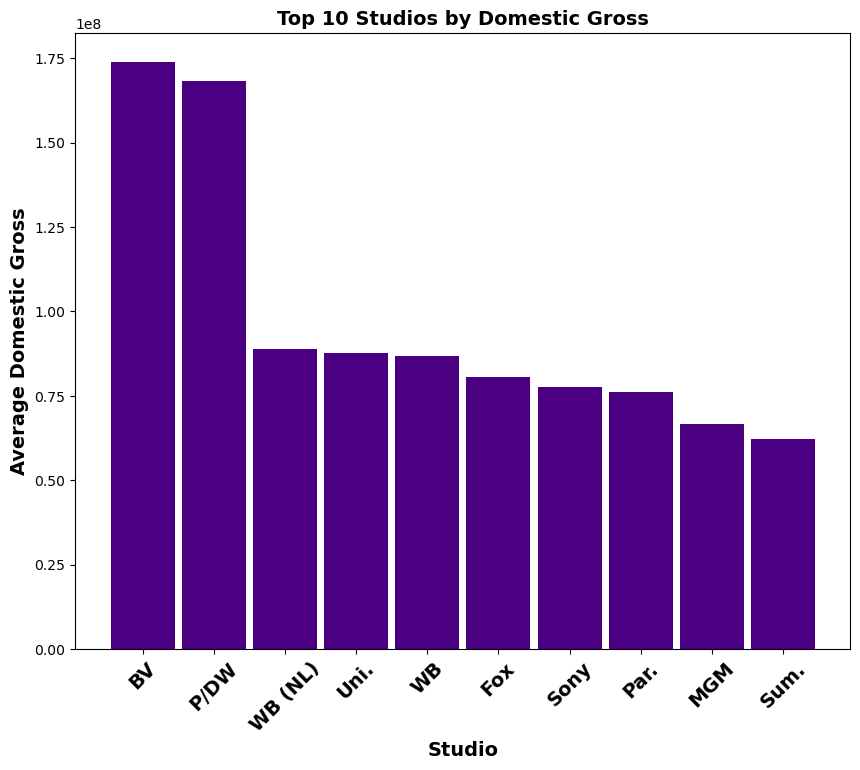

In [244]:
# Create a bar plot of the top 10 studios by domestic gross
plt.bar(top_studios.index, top_studios.values, color="indigo", width= 0.9)
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.xlabel("Studio", fontsize=14, fontweight='bold')
plt.ylabel("Average Domestic Gross", fontsize=14, fontweight='bold')
plt.title("Top 10 Studios by Domestic Gross", fontsize=14, fontweight='bold')
plt.gcf().set_size_inches(10, 8)
plt.show()

From the graph above it is evident that BV is the most preffered studio to invest in movie production by Microsoft. This is because, it recorded the highest domestic gross unlike other movies. Besides the other studios also recorded good fair returns in domestic gross and can serve as an alternative for Microsft when choosing a studio to produce the videos.

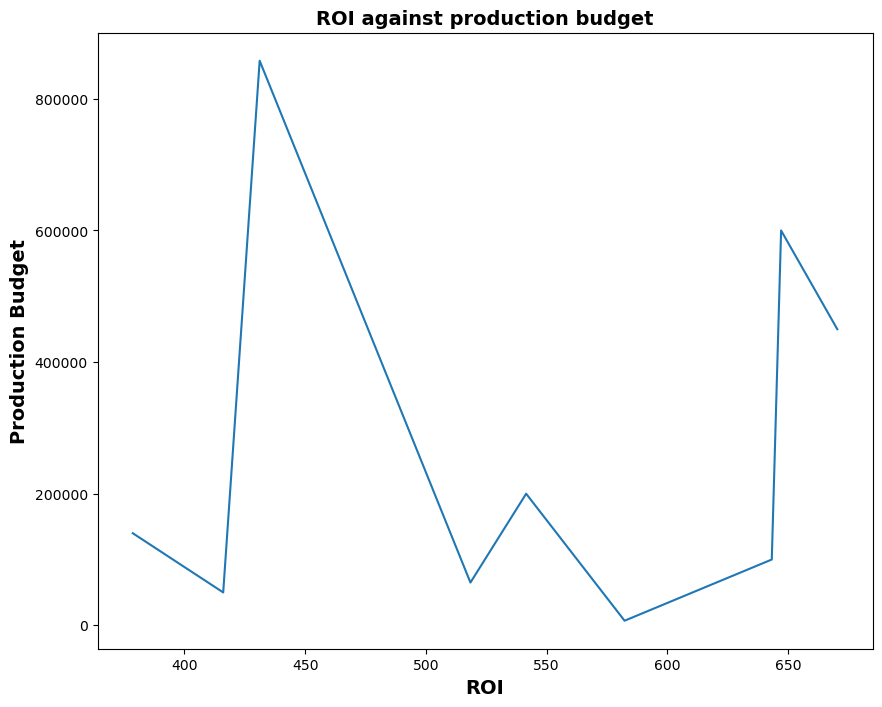

In [245]:
#ploting the line graph of ROI against the production budget
x = movie_df_sorted['ROI'] 
y = movie_df_sorted['production_budget']
plt.plot(x,y,)
plt.ylabel("Production Budget", fontsize=14, fontweight='bold')
plt.title("ROI against production budget", fontsize=14, fontweight='bold')
plt.xlabel("ROI", fontsize=14, fontweight='bold')
plt.gcf().set_size_inches(10, 8)
plt.show()

As seen from the graph above, there is no linear correlation between production budget and domestic income. This shows that a movie can be produced with alot of money and endup making lesser profits. Therefore other factors also should be taken into consideration  when determining the returns. 

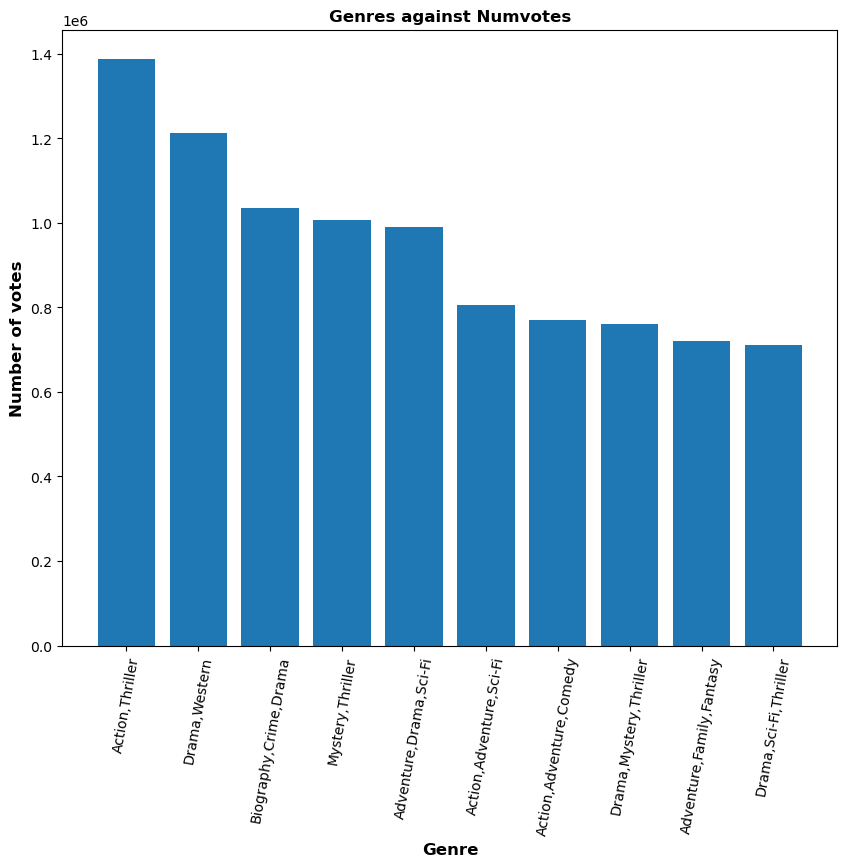

In [246]:
#plotting genres against numvotes
plt.figure(figsize=(10, 8))
plt.xticks(rotation=80, fontsize=10)
y = genres_sorted_mean["numvotes"]
plt.ylabel("Number of votes", fontsize=12, fontweight='bold')
plt.title("Genres against Numvotes", fontsize=12, fontweight='bold')
plt.xlabel("Genre", fontsize=12, fontweight='bold')
plt.bar(y.index, y.values);

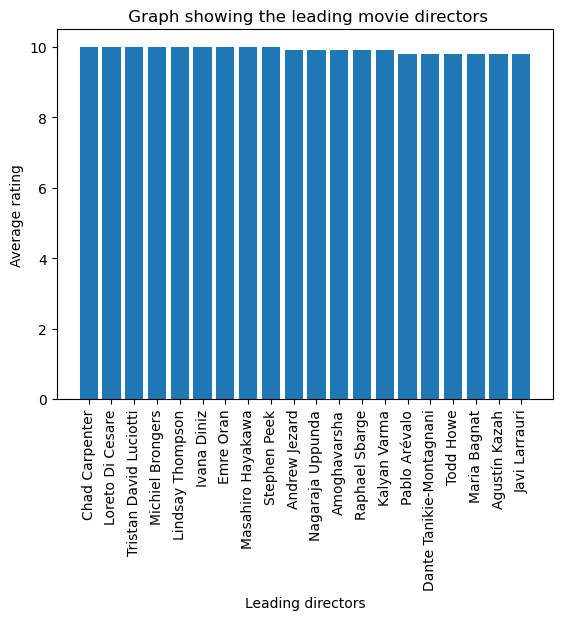

In [264]:
plt.xticks(rotation = 90)
plt.bar(populaton_of_dir["averagerating"].index, populaton_of_dir["averagerating"].values)
plt.xlabel("Leading directors")
plt.ylabel("Average rating")
plt.title(" Graph showing the leading movie directors")
plt.show()

The chart above depicts the number of people who voted for several genre collections. As seen from the visual above the most preffered genre was action and thriller followed by collection of drama and western and other respectively. The graph shows top ten prefffered collection of genres which gives the microsoft better insights in terms of genre of movies to invest in. 

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to clean the data

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions

This analysis leads to recomendations for Microsoft to utilise in the implemenation of their new movie studio:

Prioritise the creation of Action and Thriller movies as these have the highest gross and also occur the most in movies that have above average gross and average reviews.
Besides BV and P/WD are studios that are recommendable due to their prefferences as seen from its average domestic gross profits